# IMEC2201 Herramientas Computacionales 
## Semana 6: Optimización
### Clase 11-12:  Optimización y Sistemas de Bombeo

Universidad de los Andes — Mayo 11, 2022.

---

## TABLA DE CONTENIDO

### Sección 1: Optimización [→](#section1)
- 1.1. Introducción
- 1.2. Cargar Librerías
- 1.3. Sintaxis
- 1.4. Ejemplo 1
- 1.5. Ejemplo 2
- 1.6. Ejemplo 3
- 1.7. Ejemplo 4

### Sección 2: Sistema de Bombeo [→](#section2)
- 2.1. Introducción
- 2.2. Ejemplo 5
___

**¡Importante!** Note que la carpeta **week6** contiene dos archivos: `Project.toml` y `Manifest.toml`. Estos configuran el <font color="#FF5733">*ambiente de trabajo*</font> y facilitan el manejo de <font color="#FF5733">librerías</font>.

Para inicializar el ambiente desde Julia REPL, dentro de la carpeta **week6**, ejecute lo siguiente:

```shell
$ (v1.7) pkg > activate .
$ (week6) pkg> instantiate
```

**Nota:** Para acceder al Pkg REPL, escriba el corchete derecho `]` en el Julia REPL. Note que el REPL cambie de color de verde (Julia REPL) a azul (Pkg REPL). Una vez ejecutado el código `activate .`, el prefijo entre paréntesis indica el ambiente activo: cambia de `v1.7` a `week6`.

O, desde Jupyter Notebook, ejecute:

```julia
$ using Pkg
$ Pkg.activate()
$ Pkg.instantiate()
```

**Nota:** La activación del ambiente <font color="#FF5733">*precompila*</font> las librerías por lo que puede tardar un momento su ejecución completa.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Puede obtener más información en la documentación oficial de la librería [`Pkg.jl`](https://pkgdocs.julialang.org/v1/environments/) y en el documento dando clic [aquí](https://towardsdatascience.com/how-to-setup-project-environments-in-julia-ec8ae73afe9c).
</div>

In [1]:
using Pkg
Pkg.activate(pwd())
Pkg.instantiate()

  Activating project at `~/Documents/GitHub/ua-imec2001-hc-202210/content/week6`


In [2]:
Pkg.status()

      Status `~/Documents/GitHub/ua-imec2001-hc-202210/content/week6/Project.toml`
  [a93c6f00] DataFrames v1.3.4
  [39dd38d3] Dierckx v0.5.2
  [60bf3e95] GLPK v1.0.1
  [a98d9a8b] Interpolations v0.13.6
  [b6b21f68] Ipopt v1.0.2
  [4076af6c] JuMP v1.0.0
  [2774e3e8] NLsolve v4.5.1
  [91a5bcdd] Plots v1.29.0
  [f2b01f46] Roots v2.0.0


<a id="section1"></a>
# Sección 1: Optimización

## 1.1. Introducción

La optimización es la aplicación de **métodos analíticos y numéricos** enfocados a encontrar e identificar al mejor candidato de entre una colección de alternativas. 

> Un problema de optimización es un problema de decisión.

Los elementos que componen un ejercicio de optimización son:

- **Variables de decisión:** Selección de las variables independientes que sean adecuadas para caracterizar los posibles diseños candidatos y las condiciones de funcionamiento del sistema. Como variables independientes se sueleng elegir aquellas que tienen un impacto significativo sobre la función objetivo.

- **Restricciones:** Establecer mediante ecuaciones las relaciones existentes entre las variables de decisión. Estas relaciones son debidas, por ejemplo, a limitaciones en el sistema, a leyes naturales o a limitaciones tecnológicas.

- **Función objetivo:** Elemento utilizado para decidir los valores adecuados de las variables de decisión que resuelven el problema de optimización. La función objetivo permite determinar los mejores valores para las variables de decisión. También se conoce como **criterio de elección**.

> En general, la optimización indica los valores de las variables de decisión que producen el mínimo
o máximo valor (según el criterio utilizado) de la función objetivo elegida.

Algunos ejemplos de optimización son de tipo económico (coste total, beneficio), de tipo tecnológico (energía mínima, máxima capacidad de carga, máxima tasa de producción) o de tipo temporal (tiempo de producción mínimo) entre otros.

**Nota:** Únicamente se utilizará **un único criterio de optimización**, no estamos interesados en encontrar una solución que, por ejemplo, minimice el coste, maximice la producción y al mismo tiempo minimice la energía utilizada (los problemas que utilizan varios criterios de búsqueda entran dentro de la llamada optimización multiobjetivo).

Entonces:

> Un problema de optimización consiste en la búsqueda de valores para unas determinadas variables (variables de decisión) de forma que, cumpliendo un conjunto de requisitos representados mediante ecuaciones y/o inecuaciones algebráicas (restricciones) que limitarán la elección de los valores de las variables de decisión, proporcionan el mejor valor posible para una función (función objetivo) que es utilizada para medir el rendimiento del sistema que se estudia.

En otras palabras, buscamos valores que cumplan unas condiciones y minimicen o maximicen una función que caracteriza el sistema.

La sintaxis es:

$$
\begin{cases}
  \text{Optimizar} & \rightarrow f(x)\\ 
  \\
  \text{Sujeto a (S.T.)} & \rightarrow \text{Restricciones}\\
\end{cases} 
$$

Emplearemos la librería `JuMP` empleando el solucionador (*solver*) lineal `GLPK` y el no lineal `Ipopt`.

---
[1] Universidad Politécnica de Cartagena (s.f.). Fundamentos de Optimización, Capítulo 1. DMAE - UPCT.

## 1.2. Cargar Librerías

In [4]:
using JuMP
using GLPK
using Ipopt
using Plots
using Dierckx
using DataFrames
using Interpolations
using Roots 
using NLsolve 

## 1.3. Sintaxis

Utilizando un ejemplo, entendamos la sintaxis de la librería `JuMP`.

En este caso, se busca:

$$
\begin{cases}
  \text{Minimizar} & 12x + 20y\\ 
  \\
  \text{S.T.} & \begin{cases}
                  6x + 8y >= 100\\
                  \\
                  7x + 12y >= 120\\
                  \\
                  x >= 0\\
                  \\
                  y \in [0,3]
                \end{cases}
\end{cases} 
$$

Entonces:

**Paso 1.** Crear un modelo pasando un optimizador a la función `Model`:
```julia
model = Model(GLPK.Optimizer)
```

**Paso 2.** Modelar las variables con el macro `@variable()`. En este caso, las variables son:

$$
\begin{cases}
  x >= 0\\
  \\
  y \in [0,3]
\end{cases}
$$

Luego, el código es:

```julia
@variable(model, x >= 0)
@variable(model, 0 <= y <= 3)
```

**Paso 3.** Definir la función objetivo con el macro `@objective`. En este caso, esta es:

$$
\text{Minimizar} \rightarrow 12x + 20y
$$

Luego, el código es:

```julia
@objective(model, Min, 12x + 20y)
```

Si en lugar de minimizar se desea maximizat, se tiene:

```julia
@objective(model, Max, 12x + 20y)
```

Note el cambio del segundo parámetro de `Min` a `Max`.

**Paso 4.** Definir las restricciones con el macro `@constraint`. En este caso, estas son:

$$
\begin{cases}
  6x + 8y >= 100\\
  \\
  7x + 12y >= 120
\end{cases}
$$

Luego, el código es:

```julia
@constraint(model, c1, 6x + 8y >= 100)
@constraint(model, c2, 7x + 12y >= 120)
```

Siendo `c1` y `c2` son los nombres que les asignamos a las restricciones.

**Paso 5.** Resolver el ejercicio de optimización con la función `optimize!()`.

```julia
optimize!(model)
```

**Paso 6.** Extraer el resultado o valor objetivo con la función `objective_value(model)`.

In [5]:
# Paso 1
model = Model(GLPK.Optimizer)

# Paso 2
@variable(model, x >= 0)
@variable(model, 0 <= y <= 3)

# Paso 3
@objective(model, Min, 12x + 20y)

# Paso 4
@constraint(model, c1, 6x + 8y >= 100)
@constraint(model, c2, 7x + 12y >= 120)
print(model)

# Paso 5
optimize!(model)

# Paso 6
@show objective_value(model)
@show value(x)
@show value(y)

objective_value(model) = 204.99999999999997
value(x) = 15.000000000000005
value(y) = 1.249999999999996


1.249999999999996

## 1.4. Ejemplo 1

Calcular las dimensiones $x$ y $y$ del rectángulo de mayor área $A$ y de perímetro constante $p$ e igual a 48 m.

Organizando el problema, tenemos:

$$
\begin{cases}
  \text{Maximizar} & A = x y\\ 
  \\
  \text{S.T.} & \begin{cases}
                  2x + 2y = 48\\
                  \\
                  x >= 0\\
                  \\
                  y >= 0\\
                \end{cases}
\end{cases} 
$$

**Nota:** Dado que la función objetivo **no es lineal**, el *solver* a utilizar es `Ipopt` en lugar de `GLPK`. También, note que en lugar de `@objective` y `@constraint`, ahora utilizamos `@NLobjective` y `@NLconstraint`.

In [6]:
# Paso 1
model = Model(Ipopt.Optimizer)

# Paso 2
@variable(model, x >= 0, start = 0)
@variable(model, y >= 0, start = 0)

# Paso 3
@NLobjective(model, Max, x*y) # NLobjective y no objective

# Paso 4
@NLconstraint(model, c1, 2x + 2y == 48) # NLconstraint y no constraint
print(model)

# Paso 5
optimize!(model)

# Paso 6
@show objective_value(model)
@show value(x)
@show value(y)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality co

12.0

Si realizamos una verificación gráfica, tenemos que:

\begin{cases}
  A = x y & (1)\\ 
  \\
  2x + 2y = 48 & (2)
\end{cases}

Despejando $y$ en la Ecuación 2, se tiene:

$$
y = \frac{48 - 2x}{2}
$$

Reemplazando esta respuesta en la Ecuación 1, se tiene:

$$
A = x \cdot \frac{48 - 2x}{2} \: \rightarrow \: \frac{48x - 2x^2}{2} \: \rightarrow \: 24x - x^2
$$

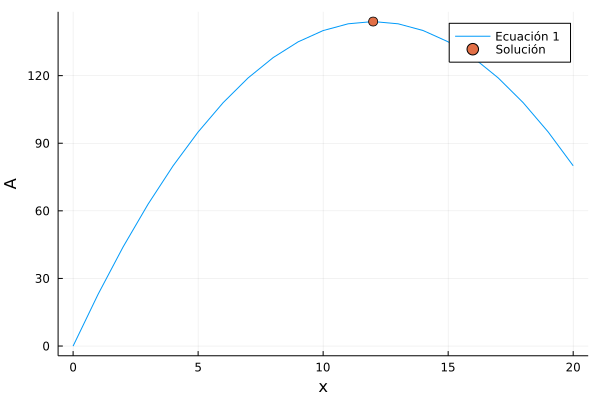

In [7]:
x = collect(0:1:20)

A(x) = 24x - x^2 # Ecuación 1

plot(x, A.(x), label="Ecuación 1")
plot!([12], [A(12)], seriestype=:scatter, m=:circle, ms=5, label="Solución")

xlabel!("x")
ylabel!("A")

## 1.5. Ejemplo 2

Una boya, formada por dos conos rectos de hierro unidos por sus bases, ha de ser construido mediante dos placas circulares de 3 m de hipotenusa. Calcular las dimensiones de la boya para que su volumen sea máximo.

<img src='./img/example2.png' width='125' height='125'/>

Organizando el problema, tenemos:

$$
\begin{cases}
  \text{Maximizar} & V = 2 \left( \frac{1}{3} \pi x^2 y \right)\\ 
  \\
  \text{S.T.} & \begin{cases}
                  x^2 + y^2 = 3^2\\
                  \\
                  x >= 0\\
                  \\
                  y >= 0\\
                \end{cases}
\end{cases} 
$$

**Nota:** Dado que la función objetivo **no es lineal**, el *solver* a utilizar es `Ipopt` en lugar de `GLPK`. También, note que en lugar de `@objective` y `@constraint`, ahora utilizamos `@NLobjective` y `@NLconstraint`.

In [9]:
# Paso 1
model = Model(Ipopt.Optimizer)

# Paso 2
@variable(model, x >= 0, start = 0)
@variable(model, y >= 0, start = 0)

# Paso 3
@NLobjective(model, Max, 2*(1/3)*π*(x^2)*y)

# Paso 4
@NLconstraint(model, c1, x^2 + y^2 == 3^2)
print(model)

# Paso 5
optimize!(model)

# Paso 6
@show objective_value(model)
@show value(x)
@show value(y)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        5

Total number of variables............................:        2
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0943888e-06 9.00e+00 1.05e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

1.7320508076021142

Si realizamos una verificación gráfica, tenemos que:

\begin{cases}
  V = 2 \left( \frac{1}{3} \pi x^2 y \right) & (1)\\ 
  \\
  x^2 + y^2 = 3^2 & (2)
\end{cases}

Despejando $x^2$ en la Ecuación 2, se tiene:

$$
x^2 = 9 - y^2
$$

Reemplazando esta respuesta en la Ecuación 1, se tiene:

$$
V = 2 \left[ \frac{1}{3} \pi (9 - y^2) y \right] \: \rightarrow \: \frac{2 \pi}{3} (9y - y^3)
$$

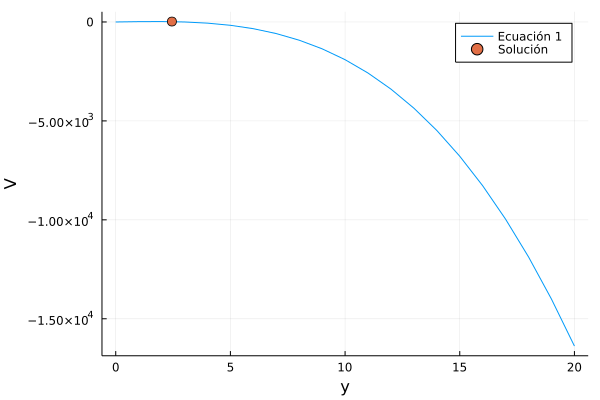

In [10]:
y = collect(0:1:20)

V(y) = (2*π/3) * (9*y - y^3) # Ecuación 1

plot(y, V.(y), label="Ecuación 1")
plot!([sqrt(6)], [V(sqrt(3))], seriestype=:scatter, m=:circle, ms=5, label="Solución")

xlabel!("y")
ylabel!("V")

## 1.6. Ejemplo 3

Dada una mochila con una capacidad de 15 kg que puedo llenar con cajas de distinto peso y valor, ¿qué cajas elijo de modo de maximizar mis ganancias y no exceder los 15 kg de peso permitidos?

<img src='./img/example3.png' width='300' height='300'/>

Organizando el problema, tenemos:

$$
\begin{cases}
  \text{Maximizar} & 4*verde + 2*azul + naranja + 10*amarillo + 2*gris\\ 
  \\
  \text{S.T.} & \begin{cases}
                  12*\text{verde} + 2*\text{azul} + \text{naranja} + 4*\text{amarillo} + \text{gris} <= 15\\
                  \\
                  \text{verde}, \text{azul}, \text{naranja}, \text{amarillo}, \text{gris} \in {0, 1}\\
                \end{cases}
\end{cases} 
$$

In [11]:
# Paso 1
model = Model(GLPK.Optimizer)

# Paso 2
@variable(model, verde, Bin) # Binary (e.g., 0 o 1)
@variable(model, azul, Bin)
@variable(model, naranja, Bin)
@variable(model, amarillo, Bin)
@variable(model, gris, Bin)

# Paso 3
@objective(model, Max, verde*4 + azul*2 + naranja*1 + amarillo*10 + gris*2)

# Paso 4
@constraint(model, peso, verde*12 + azul*2 + naranja*1 + amarillo*4 + gris*1 <= 15)
print(model)

# Paso 5
optimize!(model)

# Paso 6
@show objective_value(model)
@show value(verde)
@show value(azul)
@show value(naranja)
@show value(amarillo)
@show value(gris)

objective_value(model) = 15.0
value(verde) = 0.0
value(azul) = 1.0
value(naranja) = 1.0
value(amarillo) = 1.0
value(gris) = 1.0


1.0

## 1.7. Ejemplo 4

Una empresa de alquiler de automóviles cobra entre 50 USD por día y 200 USD por día. La curva de demanda de sus automóviles es $Q(P) = 1000 - 5P$. ¿Qué precio deberían cobrar para maximizar sus ingresos?

Organizando el problema, tenemos:

$$
\begin{cases}
  \text{Maximizar} & Ganancia = P * Q\\ 
  \\
  \text{S.T.} & \begin{cases}
                  50 <= P <= 200\\
                  \\
                  Q(P) = 1000 - 5P\\
                \end{cases}
\end{cases} 
$$

**Nota:** Dado que la función objetivo **no es lineal**, el *solver* a utilizar es `Ipopt` en lugar de `GLPK`. También, note que en lugar de `@objective` y `@constraint`, ahora utilizamos `@NLobjective` y `@NLconstraint`.

In [13]:
# Paso 1
model = Model(Ipopt.Optimizer)

# Paso 2
@variable(model, 50 <= P <= 200, start = 50)

# Paso 3
@NLobjective(model, Max, P * (1000 - 5P)) # Revenue = P * Q

# Paso 4
# @constraint() # No hay a parte de los costos de alquiler
print(model)

# Paso 5
optimize!(model)

# Paso 6
@show objective_value(model)
@show value(P)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.7748750e+04 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

100.00000000001253

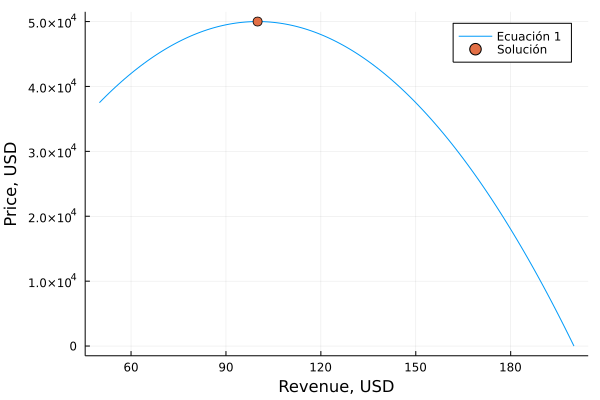

In [14]:
P = collect(50:1:200)

revenue(P) = P * (1000 - 5P) # Ecuación 1

plot(P, revenue.(P), label="Ecuación 1")
plot!([100], [revenue(100)], seriestype=:scatter, m=:circle, ms=5, label="Solución")

xlabel!("Revenue, USD")
ylabel!("Price, USD")

<a id="section2"></a>
# Sección 2: Sistema de Bombeo

## 2.1. Introducción

Recordemos lo que conversamos de las bombas centrífugas.

La potencia que la bomba centrífuga le añade al fluido (conocida como **potencia hidráulica** $P_w$), es:

$$
P_w = \rho g Q H
$$

Donde $\rho$ es la densidad del fluido, $g$ la gravedad, $Q$ el caudal y $H$ la altura manométrica, definida como:

$$
H = \frac{\Delta p}{\rho g}
$$

Siendo $\Delta p$ el cambio de presión entre la entrada y salida de la bomba centrífuga.

Cuando bombeamos un fluido en una tubería, debemos tener presente la fricción dada por las paredes del conducto causan una pérdida de carga $h_f$.

$$
h_f = f \frac{L}{D} \frac{V^2}{2g}
$$

Siendo $f$ el **coeficiente de fricción de Darcy** y $g$ la gravedad.

Entonces, estas pérdidas por fricción en la tubería afecta la cabeza manométrica así: $H - h_f$.

En general, el coeficiente de fricción de Darcy es función del número de Reynolds $Re$ y la rugosidad de la pared $\varepsilon$.

El número de Reynolds $Re$ una relación entre las *fuerzas de inercia* y las *fuerzas viscosas* de un fluido que permiten determinar si el flujo es laminar o turbulento.

$$
Re = \frac{\rho V D}{\mu} = \frac{V D}{\nu}
$$

Siendo $\rho$ la densidad del fluido, $V$ la velocidad de flujo, $D$ el diámetro interno de la tubería, $\mu$ la viscosidad dinámica del fluido y $\nu$ la viscosidad cinemática del fluido.

Típicamente:
- Flujo laminar cuando $Re <= 2300$. Para este caso, el coeficiente de fricción de Darcy es:

$$
f = \frac{64}{Re}
$$

- Flujo turbulento cuando $Re > 2300$. Para este caso, el coeficiente de fricción de Darcy es:

$$
\frac{1}{\sqrt{f}} = -2 \: \text{log} \left( \frac{\varepsilon / D}{3.7} + \frac{2.51}{Re \sqrt{f}} \right)
$$

Esta ecuación es también conocida como la *ecuación de Colebrook*.


Ahora bien, para que la bomba centrífuga le añada energía al fluido, debe haber un recurso que, asimismo, le suministre energía al dispositivo. Esto último es conocido como **potencia mecánica** $P_f$ y es el producto entre la velocidad de rotación del eje de la bomba $w$ y el torque en el mismo $T$.

$$
P_f = w T
$$

Luego, si el insumo es $P_f$ y la salida es $P_w$, la eficiencia de la bomba es la relación entre estos parámetros, es decir:

$$
\eta = \frac{P_w}{P_f} = \frac{\rho g Q H}{w T}
$$

Entonces, el rendimiento de la bomba centrífuga depende de tres factores: volumétrico, hidráulico y mecánico.

<img src='./img/curvas_teoricas.png' width='400' height='400' />

En la práctica, aunque las curvas de la altura manométrica $H$ aparecen explícitamente, las de potencia $P_f$ y rendimiento $\eta$ deben deducirse a partir de los datos medidos. Fíjense, **es como los laboratorios que hacemos en los cursos de ingeniería mecánica**.

<img src='./img/curvas_reales.png' width='900' height='900' />

Por último, recordemos que:

$$
Q = VA
$$

y

$$
A = \frac{\pi D^2}{4}
$$

Siendo $A$ el área transversal de la tubería.

Dicho esto, ¡optimicemos un sistema de bombeo!

## 2.2. Ejemplo 5

Para las mediciones de los datos de caudal $Q$ y, sabiendo que la velocidad de rotación del eje de la bomba $w$ es 1170 rpm, optimicemos la eficiencia de la bomba $\eta$. Asumimos $\rho g = 1$. Para esto:

$$
\begin{cases}
  \text{Maximizar} & \eta = \frac{P_w}{P_f} = \frac{\rho g Q H}{w T}\\ 
  \\
  \text{S.T.} & \begin{cases}
                  w = 1170\\
                  \\
                  0 \leq Q \leq 26\\
                  \\
                  460 \leq H \leq 655\\
                  \\
                  T \geq 0
                \end{cases}
\end{cases} 
$$

In [16]:
# Paso 1
model = Model(Ipopt.Optimizer)

# Paso 2
@variable(model, 0 <= η <= 1)
@variable(model, w == 1170)
@variable(model, 0 <= Q <= 26)
@variable(model, 460 <= H <= 655)
@variable(model, T >= 0)

# Paso 3
@NLobjective(model, Max, (Q*H)/(w*T))

# Paso 4
@NLconstraint(model, c1, T == (Q*H) / (w * η))
print(model)

# Paso 5
optimize!(model)

# Paso 6
@show objective_value(model)
@show value(η)
@show value(w)
@show value(Q)
@show value(H)
@show value(T)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:        4
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9482906e-01 3.85e-01 3.95e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

0.0005235922252472519